# Jupyter notebook version of unofficial  PyTorch implementation for "BAM: Bottleneck Attention Module (BMVC2018)"

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Assign GPU

In [2]:
GPU = 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
batch_size = 32
learning_rate = 0.01

In [5]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='../../data/', train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.CIFAR10(
    root='../../data/', train=False, transform=transforms.ToTensor()
)
# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

Files already downloaded and verified


In [6]:
cifar_classes = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

In [7]:
print(len(train_dataset), len(train_loader))
print(len(test_dataset), len(test_loader))

50000 1563
10000 313


## Check sample data in CIFAR-10

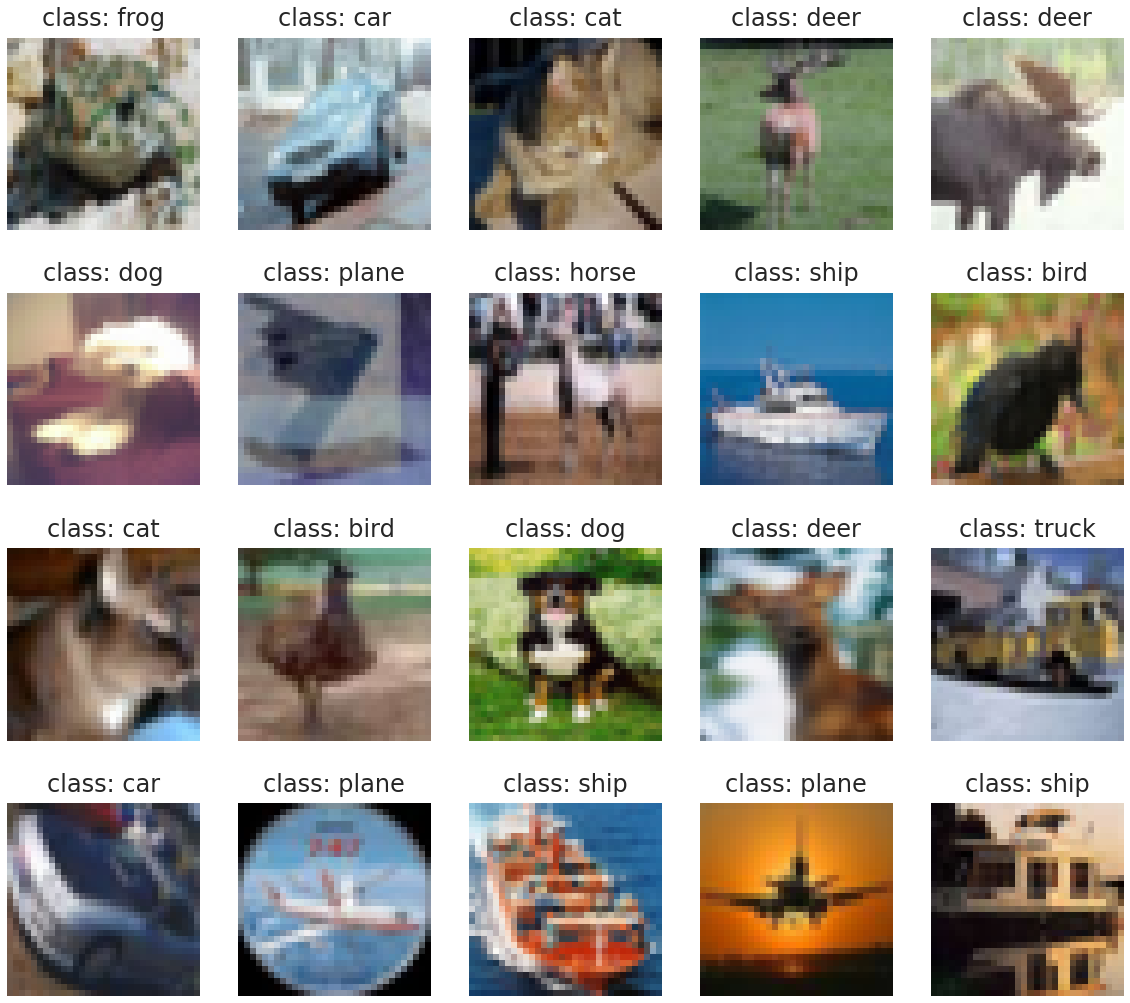

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set(style="white", font_scale=2)
fig, ax = plt.subplots(4, 5, figsize=(20, 18))
ax = ax.flat
for i in range(len(ax)):
    smp_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, lbl = test_dataset[smp_idx]
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].set_title("class: {}".format(cifar_classes[lbl]), pad=12)
    ax[i].axis("off")

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        out = x.view(x.size(0), -1)
        return out

In [10]:
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, num_layers=1):
        super(ChannelGate, self).__init__()
        # Number of input channels (filters)
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.BatchNorm1d(gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
    
    def forward(self, x):
        # Global Average Pooling (GAP)
        avg_pool = F.avg_pool2d(x, x.size(2), stride=x.size(2))
        out = self.mlp(avg_pool)
        out = out.unsqueeze(2).unsqueeze(3).expand_as(x)
        return out

In [11]:
class SpatialGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, n_dilation=2, dilation_val=4):
        super(SpatialGate, self).__init__()
        # Number of input channels (filters)
        self.gate_channels = gate_channels
        self.reduced_channel = gate_channels // reduction_ratio
        self.conv = nn.Sequential(
            nn.Conv2d(gate_channels, self.reduced_channel, kernel_size=1),
            nn.BatchNorm2d(self.reduced_channel),
            nn.ReLU(),
            nn.Conv2d(
                self.reduced_channel, self.reduced_channel, kernel_size=3, 
                padding=dilation_val, dilation=dilation_val),
            nn.BatchNorm2d(self.reduced_channel),
            nn.ReLU(),
            nn.Conv2d(
                self.reduced_channel, self.reduced_channel, kernel_size=3, 
                padding=dilation_val, dilation=dilation_val),
            nn.BatchNorm2d(self.reduced_channel),
            nn.ReLU(),
            nn.Conv2d(self.reduced_channel, 1, kernel_size=1)
        )

    def forward(self, x):
        out = self.conv(x).expand_as(x)
        return out

In [12]:
class BAM(nn.Module):
    def __init__(self, gate_channels):
        super(BAM, self).__init__()
        self.channel_att = ChannelGate(gate_channels)
        self.spatial_att = SpatialGate(gate_channels)
    
    def forward(self, x):
        att_map = torch.sigmoid(torch.add(self.channel_att(x), self.spatial_att(x)))
        out = x + att_map * x
        return out

In [13]:
def conv_3x3(in_planes, out_planes, stride=1):
    conv = nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )
    return conv

In [14]:
class BasicBlock(nn.Module):
    expansion = 1 # dilation
    
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv_1 = conv_3x3(in_planes, out_planes, stride)
        self.bn_1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv_2 = conv_3x3(out_planes, out_planes)
        self.bn_2 = nn.BatchNorm2d(out_planes)
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        out = self.conv_1(x)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.conv_2(out)
        out = self.bn_2(out)
        
        if self.downsample != None:
            residual = self.downsample(x)
                
        out += residual
        out = self.relu(out)
        
        return out

In [15]:
class Bottleneck(nn.Module):
    expansion = 4 # dilation
    
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv_1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(out_planes)
        self.conv_2 = nn.Conv2d(
            out_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn_2 = nn.BatchNorm2d(out_planes)
        self.conv_3 = nn.Conv2d(out_planes, out_planes * 4, kernel_size=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(out_planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        out = self.conv_1(x)
        out = self.bn_1(out)
        out = self.relu(out)
        
        out = self.conv_2(out)
        out = self.bn_2(out)
        out = self.relu(out)

        out = self.conv_3(out)
        out = self.bn_3(out)

        if self.downsample != None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, layers, network_type, num_classes, att_type=None):
        self.in_planes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        if network_type == "ImageNet":
            self.conv_1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        elif network_type == "CIFAR10":
            self.conv_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn_1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        if att_type == "BAM":
            self.bam_1 = BAM(64 * block.expansion)
            self.bam_2 = BAM(128 * block.expansion)
            self.bam_3 = BAM(256 * block.expansion)
        else:
            self.bam_1, self.bam_2, self.bam_3 = None, None, None
        
        self.layer_1 = self._make_layer(block, 64, layers[0])
        self.layer_2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer_3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer_4 = self._make_layer(block, 512, layers[3], stride=2)
            
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        nn.init.kaiming_normal_(self.fc.weight)
        for key in self.state_dict():
            if key.split("."[-1]) == "weight":
                if "conv" in key:
                    nn.init.kaiming_normal_(self.state_dict()[key], mode="fan_out")
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1] == "bias":
                self.state_dict()[key][...] = 0
                
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False), 
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(
            self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        
        x = self.layer_1(x)
        if self.bam_1 != None:
            x = self.bam_1(x)
        
        x = self.layer_2(x)
        if self.bam_2 != None:
            x = self.bam_2(x)

        x = self.layer_3(x)
        if self.bam_3 != None:
            x = self.bam_3(x)
        
        x = self.layer_4(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [17]:
def ResidualNet(network_type, depth, num_classes, att_type):
    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [18, 34, 50, 101], "network depth should be 18, 34, 50 or 101"

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)
    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)
    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)
    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)
    
    return model

In [18]:
depth = 50
num_classes = 10
epochs = 100
batch_size = batch_size
momentum = 0.90
l2_param = 1e-04

In [19]:
model = ResidualNet("CIFAR10", depth, num_classes, "BAM").to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(
    model.parameters(), learning_rate, momentum=momentum, weight_decay=l2_param
)
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer=optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch // 30))

## Training ResNet50 + BAM

In [20]:
train_loss_list = []
test_loss_list = []
train_acc_list = []    
test_acc_list = []

for epoch in range(epochs):
    # Training the model
    model.train()
    running_train_loss = 0
    running_test_loss = 0
    running_train_top_1_acc, running_train_top_5_acc = 0, 0
    running_test_top_1_acc, running_test_top_5_acc = 0, 0
    
    for train_batch_idx, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        output = model(input)
        loss = criterion(output, target)
        
        # Calculate top-1, top-5 accuracy
        top_k = (1, 5)
        max_k = max(top_k)
        _, pred = output.data.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        tmp_acc = []
        for k in top_k:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            tmp_acc.append(correct_k.mul_(100.0 / target.size(0)))
        top_1_acc, top_5_acc = tmp_acc[0], tmp_acc[1]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss
        running_train_top_1_acc += top_1_acc
        running_train_top_5_acc += top_5_acc
            
    train_loss = running_train_loss.item() / train_batch_idx
    train_top_1_acc = running_train_top_1_acc.item() / (train_batch_idx + 1)
    train_top_5_acc = running_train_top_5_acc.item() / (train_batch_idx + 1)
    train_loss_list.append(train_loss)
    train_acc_list.append([train_top_1_acc, train_top_5_acc])
    
    scheduler.step()

    # Evaluating trained model
    model.eval()
    with torch.no_grad():
        for test_batch_idx, (input, target) in enumerate(test_loader):
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = criterion(output, target)
            
            # Calculate top-1, top-5 accuracy
            top_k = (1, 5)
            max_k = max(top_k)
            _, pred = output.data.topk(max_k, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            tmp_acc = []
            for k in top_k:
                correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
                tmp_acc.append(correct_k.mul_(100.0 / target.size(0)))
            top_1_acc, top_5_acc = tmp_acc[0], tmp_acc[1]
        
            running_test_loss += loss
            running_test_top_1_acc += top_1_acc
            running_test_top_5_acc += top_5_acc

    test_loss = running_test_loss.item() / test_batch_idx
    test_top_1_acc = running_test_top_1_acc.item() / (test_batch_idx + 1)
    test_top_5_acc = running_test_top_5_acc.item() / (test_batch_idx + 1)
    test_loss_list.append(test_loss)
    test_acc_list.append([test_top_1_acc, test_top_5_acc])

    print("Epoch [{}/{}]".format(epoch + 1, epochs))
    print("train loss: {:.4f}, train top-1: {:.2f}%, train top-5: {:.2f}%".format(
        train_loss, train_top_1_acc, train_top_5_acc))
    print("test loss: {:.4f}, test top-1: {:.2f}%, test top-5: {:.2f}%".format(
        test_loss, test_top_1_acc, test_top_5_acc))

Epoch [1/100]
train loss: 1.7598, train top-1: 37.39%, train top-5: 86.88%
test loss: 1.6673, test top-1: 47.21%, test top-5: 90.23%
Epoch [2/100]
train loss: 1.2305, train top-1: 56.22%, train top-5: 94.64%
test loss: 1.3146, test top-1: 57.57%, test top-5: 95.38%
Epoch [3/100]
train loss: 0.9632, train top-1: 66.12%, train top-5: 96.86%
test loss: 1.1089, test top-1: 66.08%, test top-5: 97.14%
Epoch [4/100]
train loss: 0.7873, train top-1: 72.68%, train top-5: 97.99%
test loss: 0.6741, test top-1: 77.07%, test top-5: 98.62%
Epoch [5/100]
train loss: 0.6568, train top-1: 77.21%, train top-5: 98.61%
test loss: 0.6061, test top-1: 79.25%, test top-5: 98.97%
Epoch [6/100]
train loss: 0.5615, train top-1: 80.69%, train top-5: 98.97%
test loss: 0.5456, test top-1: 81.21%, test top-5: 99.11%
Epoch [7/100]
train loss: 0.5060, train top-1: 82.52%, train top-5: 99.22%
test loss: 0.4821, test top-1: 83.59%, test top-5: 99.35%
Epoch [8/100]
train loss: 0.4567, train top-1: 84.36%, train top-5: 9

# Check learning curves

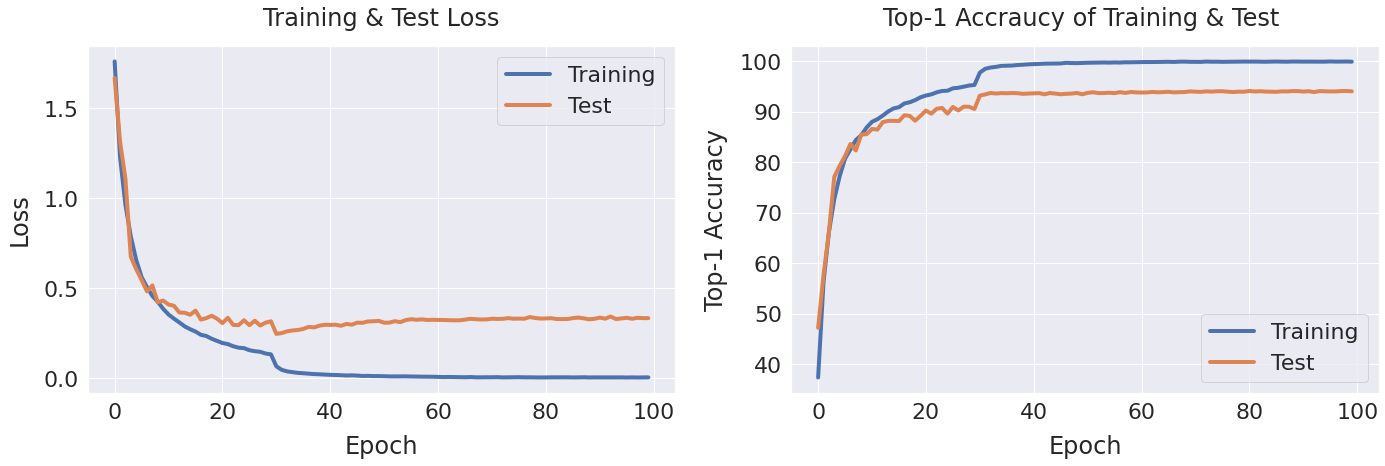

In [55]:
sns.set(style="darkgrid", font_scale=2)
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(train_loss_list, lw=4, label="Training")
ax[0].plot(test_loss_list, lw=4, label="Test")
ax[1].plot(np.array(train_acc_list)[:, 0], lw=4, label="Training")
ax[1].plot(np.array(test_acc_list)[:, 0], lw=4, label="Test")
ax[0].set_xlabel("Epoch", labelpad=12)
ax[0].set_ylabel("Loss", labelpad=12)
ax[1].set_xlabel("Epoch", labelpad=12)
ax[1].set_ylabel("Top-1 Accuracy", labelpad=12)
ax[0].legend(); ax[1].legend()
ax[0].set_title("Training & Test Loss", pad=20)
ax[1].set_title("Top-1 Accraucy of Training & Test ", pad=20)
plt.tight_layout(); plt.show()

In [21]:
model.eval()

for test_batch_idx, (input, target) in enumerate(test_loader):
    
    if test_batch_idx != 0: 
        break
    
    input, target = input.to(device), target.to(device)
    output = model(input)
    loss = criterion(output, target)

    # Calculate top-1, top-5 accuracy
    tmp_prd = output.data
    top_k = (1, 5)
    max_k = max(top_k)
    _, pred = output.data.topk(max_k, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    tmp_acc = []
    for k in top_k:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        tmp_acc.append(correct_k.mul_(100.0 / target.size(0)))
    top_1_acc, top_5_acc = tmp_acc[0].item(), tmp_acc[1].item()
    print("top-1: {:.2f}, top-5: {:.2f}".format(top_1_acc, top_5_acc))
    tmp_img, tmp_prd, tmp_lbl = input, pred, target

top-1: 96.88, top-5: 100.00


# Check sample predictions in test dataset 

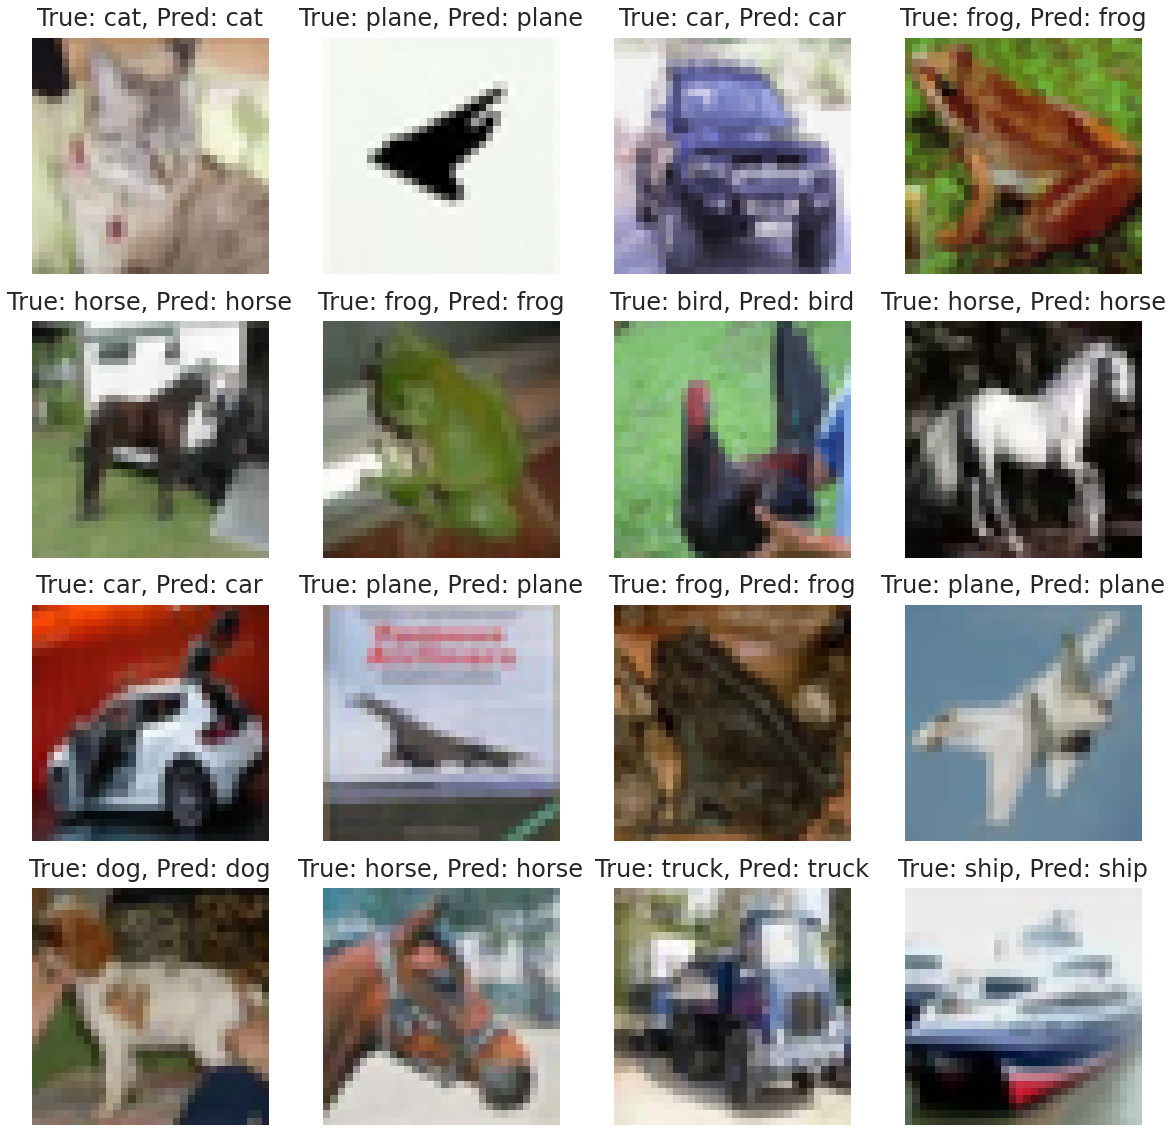

In [22]:
sns.set(style="white", font_scale=2)
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.flat
rand_idx = np.random.choice(np.arange(target.size(0)), 16, replace=False)

for i in range(len(ax)):
    tmp_idx = rand_idx[i]
    ax[i].imshow(tmp_img[tmp_idx].permute(1, 2, 0).detach().cpu().numpy())
    ax[i].set_title("True: {}, Pred: {}".format( 
        cifar_classes[tmp_lbl[tmp_idx]], cifar_classes[tmp_prd[0, tmp_idx]]), pad=12)
    ax[i].axis("off")